In [1]:
!git clone https://github.com/HoanChan/TableVision.git

Cloning into 'TableVision'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 134 (delta 12), reused 46 (delta 6), pack-reused 81
Receiving objects: 100% (134/134), 209.71 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (71/71), done.


In [2]:
!git clone https://github.com/microsoft/table-transformer

Cloning into 'table-transformer'...
remote: Enumerating objects: 753, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 753 (delta 338), reused 383 (delta 304), pack-reused 321
Receiving objects: 100% (753/753), 356.09 KiB | 6.59 MiB/s, done.
Resolving deltas: 100% (466/466), done.


In [3]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 13.1 MB/s eta 0:00:00


In [4]:
def split_pth_file(input_file, output_file1, output_file2):
    with open(input_file, 'rb') as f:
        data = f.read()

    half_len = len(data) // 2

    with open(output_file1, 'wb') as f1, open(output_file2, 'wb') as f2:
        f1.write(data[:half_len])
        f2.write(data[half_len:])

def combine_pth_files(input_file1, input_file2, output_file):
    with open(input_file1, 'rb') as f1, open(input_file2, 'rb') as f2:
        data1 = f1.read()
        data2 = f2.read()

    combined_data = data1 + data2

    with open(output_file, 'wb') as f:
        f.write(combined_data)

In [5]:
combine_pth_files("/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_detection_detr_r18.pth")
combine_pth_files("/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part1", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth_part2", "/content/TableVision/models/pubtables1m_structure_detr_r18.pth")


In [6]:
import sys
# Thêm đường dẫn đến thư mục 'src' vào danh sách đường dẫn
sys.path.append('/content/TableVision/')
sys.path.append('/content/table-transformer/')
sys.path.append('/content/table-transformer/src/')
sys.path.append('/content/table-transformer/detr/')

from src.inference import TableExtractionPipeline

# Create inference pipeline
pipe = TableExtractionPipeline(det_config_path='/content/table-transformer/src/detection_config.json',
                               det_model_path='/content/TableVision/models/pubtables1m_detection_detr_r18.pth', det_device='cuda',
                               str_config_path='/content/table-transformer/src/structure_config.json',
                               str_model_path='/content/TableVision/models/pubtables1m_structure_detr_r18.pth', str_device='cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


Detection model initialized.
Detection model weights loaded.
Structure model initialized.
Structure model weights loaded.


In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from src.inference import visualize_detected_tables, visualize_cells

def deleteFile(file_path):
  try:
      # Thực hiện xoá file
      import os
      os.remove(file_path)
      print(f"{file_path} đã được xoá thành công.")
  except FileNotFoundError:
      print(f"File {file_path} không tồn tại.")
  except Exception as e:
      print(f"Lỗi khi xoá file {file_path}: {e}")

def crop(img, bbox, margin = 10, padding = 20):
  # Tạo ảnh mới có kích thước lớn hơn để chứa ảnh cũ và padding
  crop_img = img.crop((bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin))
  new_width = crop_img.width + 2 * padding
  new_height = crop_img.height + 2 * padding
  # Tạo ảnh mới với kích thước lớn hơn
  new_img = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Màu nền trắng, bạn có thể thay đổi nếu muốn
  # Đặt ảnh cũ vào vị trí giữa ảnh mới
  new_img.paste(crop_img, (padding, padding))
  return new_img

def detectTable(pipe, img_path):
  img = Image.open(img_path)
  tokens = {}
  extracted_tables = pipe.detect(img)
  print(extracted_tables)
  visualize_detected_tables(img, extracted_tables['objects'], "/content/0.jpg")
  img_tables = Image.open("/content/0.jpg")
  img_data = [(img, img_tables)]
  for index, objects in enumerate(extracted_tables['objects']):
    bbox = objects['bbox']
    cropped_img = crop(img, bbox, 10, 20)
    extracted_cell = pipe.recognize(cropped_img, tokens, out_objects=True, out_cells=True, out_html=True, out_csv=True)
    cells = extracted_cell['cells']
    csv = extracted_cell['csv']
    html = extracted_cell['html']
    visualize_cells(cropped_img, cells[0], "/content/2.jpg")
    img_cell = Image.open('/content/2.jpg')
    img_data += [(cropped_img, img_cell)]

  num_img = 1 + len(extracted_tables)

  plt.figure(figsize=(10, 5*num_img))
  plot_size = num_img * 100 + 20
  for index, imgs in enumerate(img_data):
    img1, img2 = imgs
    plt.subplot(plot_size + index * 2 + 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(plot_size + index * 2 + 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')

  plt.show()
  deleteFile("/content/0.jpg")
  deleteFile("/content/1.jpg")
  deleteFile("/content/2.jpg")


In [8]:
import matplotlib.pyplot as plt
from PIL import Image
from src.inference import visualize_detected_tables, visualize_cells

def deleteFile(file_path):
  try:
      # Thực hiện xoá file
      import os
      os.remove(file_path)
      print(f"{file_path} đã được xoá thành công.")
  except FileNotFoundError:
      print(f"File {file_path} không tồn tại.")
  except Exception as e:
      print(f"Lỗi khi xoá file {file_path}: {e}")

def crop(img, bbox, margin = 10, padding = 20):
  # Tạo ảnh mới có kích thước lớn hơn để chứa ảnh cũ và padding
  crop_img = img.crop((bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin))
  new_width = crop_img.width + 2 * padding
  new_height = crop_img.height + 2 * padding
  # Tạo ảnh mới với kích thước lớn hơn
  new_img = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Màu nền trắng, bạn có thể thay đổi nếu muốn
  # Đặt ảnh cũ vào vị trí giữa ảnh mới
  new_img.paste(crop_img, (padding, padding))
  return new_img

def detectTable(pipe, img_path):
  img = Image.open(img_path)
  tokens = {}
  extracted_tables = pipe.detect(img)
  print(extracted_tables)
  visualize_detected_tables(img, extracted_tables['objects'], "/content/0.jpg")
  img_tables = Image.open("/content/0.jpg")
  img_data = [(img, img_tables)]
  for index, objects in enumerate(extracted_tables['objects']):
    bbox = objects['bbox']
    cropped_img = crop(img, bbox, 10, 20)
    extracted_cell = pipe.recognize(cropped_img, tokens, out_objects=True, out_cells=True, out_html=True, out_csv=True)
    cells = extracted_cell['cells']
    csv = extracted_cell['csv']
    html = extracted_cell['html']
    visualize_cells(cropped_img, cells[0], "/content/2.jpg")
    img_cell = Image.open('/content/2.jpg')
    img_data += [(cropped_img, img_cell)]

  num_img = 1 + len(img_data)

  plt.figure(figsize=(10, 5*num_img))
  plot_size = num_img * 100 + 20
  for index, imgs in enumerate(img_data):
    img1, img2 = imgs
    plt.subplot(plot_size + index * 2 + 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(plot_size + index * 2 + 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')

  plt.show()
  deleteFile("/content/0.jpg")
  deleteFile("/content/1.jpg")
  deleteFile("/content/2.jpg")


{'objects': [{'label': 'table', 'score': 0.9970731735229492, 'bbox': [46.57670974731445, 108.19696044921875, 583.6276245117188, 329.9461669921875]}]}


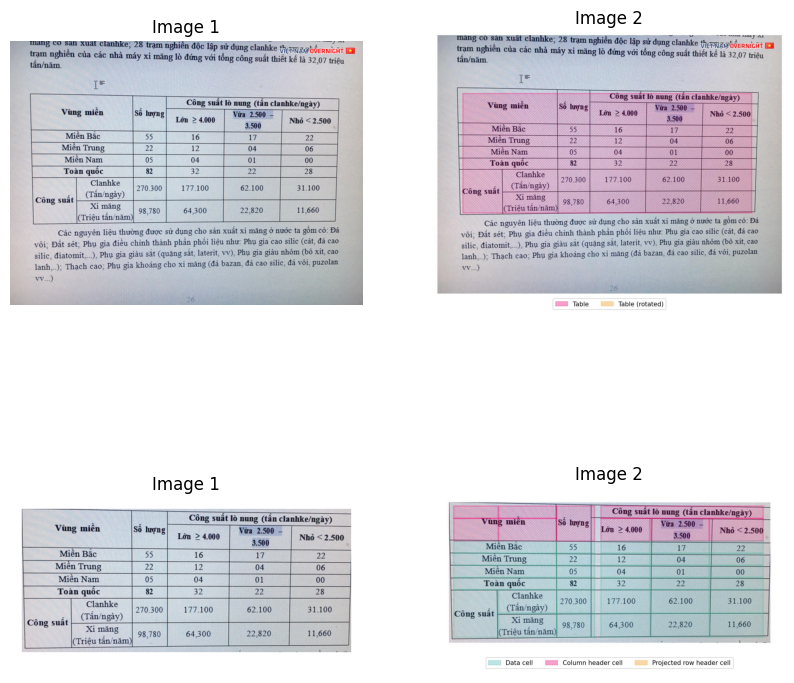

In [9]:
detectTable(pipe, "/content/TableVision/sample/vn0.jpg")

/content/0.jpg đã được xoá thành công.
File /content/1.jpg không tồn tại.
/content/2.jpg đã được xoá thành công.
{'objects': [{'label': 'table', 'score': 0.9928743839263916, 'bbox': [72.52954864501953, 172.25640869140625, 1086.146728515625, 590.3809204101562]}, {'label': 'table', 'score': 0.9742115139961243, 'bbox': [70.99385833740234, 647.8134155273438, 1136.359130859375, 1142.6983642578125]}]}


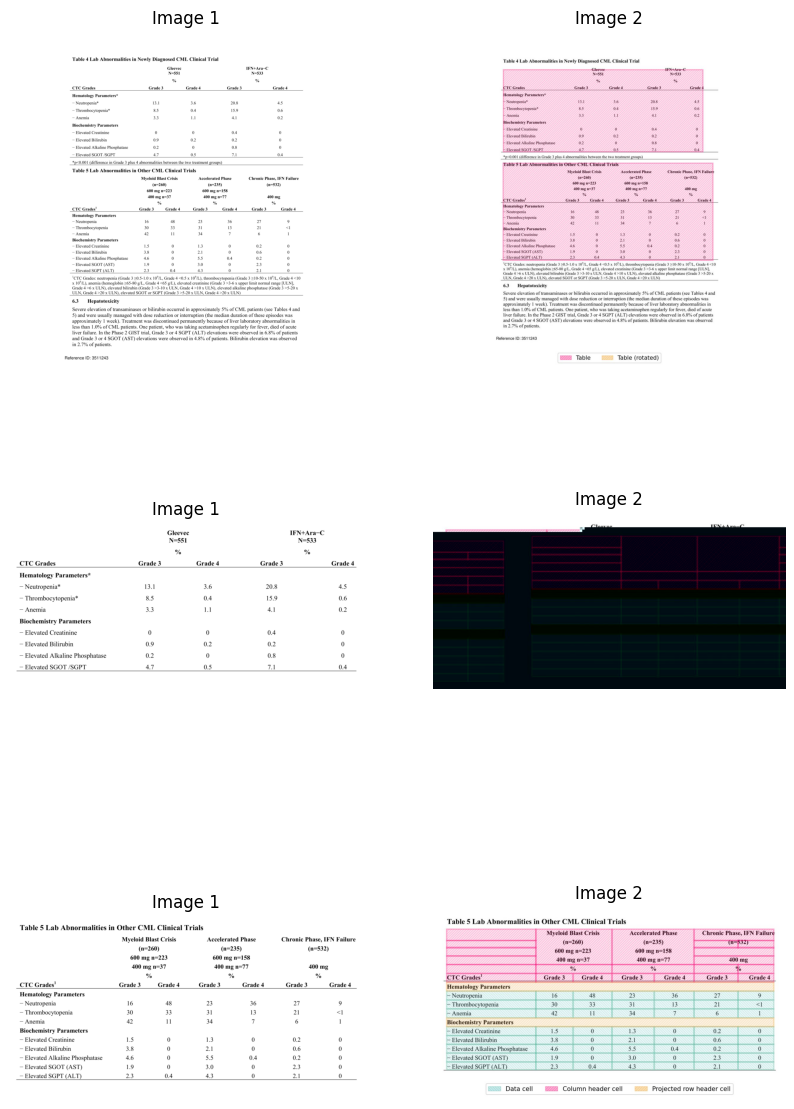

/content/0.jpg đã được xoá thành công.
File /content/1.jpg không tồn tại.
/content/2.jpg đã được xoá thành công.


In [10]:
detectTable(pipe, "/content/TableVision/sample/tablex2.png")

{'objects': [{'label': 'table', 'score': 0.9998012185096741, 'bbox': [21.200403213500977, 45.51911544799805, 653.7255249023438, 281.7128601074219]}]}


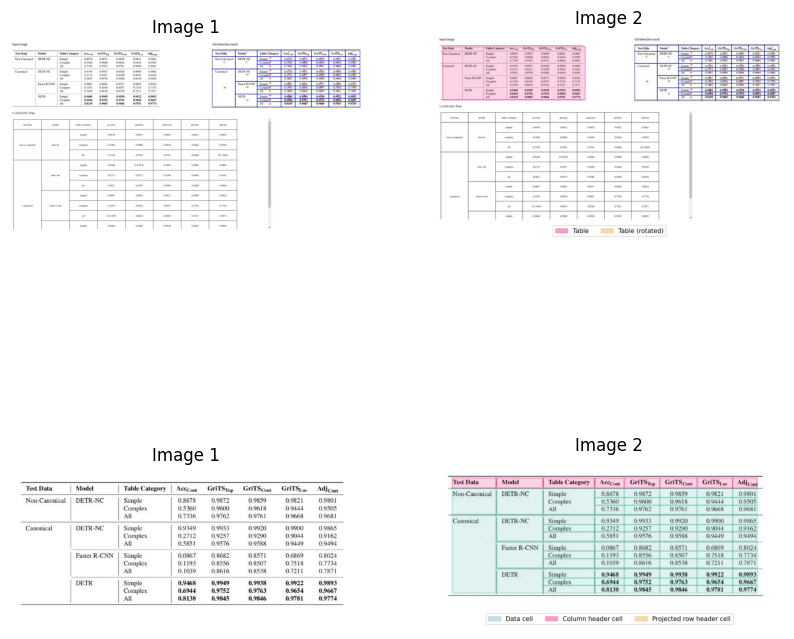

/content/0.jpg đã được xoá thành công.
File /content/1.jpg không tồn tại.
/content/2.jpg đã được xoá thành công.


In [22]:
# detectTable(pipe, "/content/TableVision/sample/tablex3.png")
original_image = Image.open("/content/TableVision/sample/tablex3.png")
original_image.convert('RGB').save("new_image.jpg", 'JPEG')
detectTable(pipe, "/content/new_image.jpg")